<a href="https://colab.research.google.com/github/mateusgoto01/appAutoProject/blob/main/2_DataPreprocessing_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's Import the Libraries to be used:

## 1. Let's download the libraries we'll be using

In [1]:
%pip install feature_engine

In [2]:
%pip install umap-learn

In [24]:
%pip install statsmodels

In [31]:
%pip install scipy

## 2. Let's import the libraries


In [132]:
import numpy as np
import  pandas as pd
import  seaborn as sns
import  scipy.stats as stats
import  matplotlib.pyplot as plt

import  plotly
import  plotly.graph_objs as go
import  plotly.io as pio
from plotly.subplots import make_subplots
import  plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import  cufflinks as cf
import  plotly.figure_factory as ff
from plotly.offline import iplot
from plotly import tools
from ipywidgets import widgets

from matplotlib.colors import to_rgba

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.dpi'] = 100
colors = px.colors.qualitative.Prism
pio.templates.default = "plotly_white"

<ipython-input-132-98a8a04bf09f>:21: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



Libraries for data analysis:

In [133]:
from sklearn.model_selection import train_test_split
from feature_engine.imputation import CategoricalImputer
from feature_engine import transformation as vt
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder
from feature_engine.imputation import AddMissingIndicator
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import pearsonr


In [136]:
target_variable_names=["Yield strength / MPa",
        "Ultimate tensile strength / MPa",
        "Elongation / %",
        "Reduction of Area / %",
        "Charpy temperature / °C",
        "Charpy impact toughness / J",]

In [137]:
X_train=pd.read_csv('data/train.csv',)
y_train=X_train[target_variable_names]
X_train.drop(columns=target_variable_names + ["Unnamed: 0"], inplace=True)


X_valid=pd.read_csv('data/validation.csv')
y_valid=X_valid[target_variable_names]
X_valid.drop(columns=target_variable_names + ["Unnamed: 0"],inplace=True)


X_test=pd.read_csv('data/test.csv')
y_test=X_test[target_variable_names]
X_test.drop(columns=target_variable_names + ["Unnamed: 0"],inplace=True)


In [138]:
X_train

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Post weld heat treatment temperature / °C,Post weld heat treatment time / hours,Hardness / kgmm-2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggreagate / %,Weld ID
0,0.075,0.35,0.80,0.020,0.017,NaN,2.300,1.50,NaN,NaN,...,690.0,3.00,220.0,NaN,NaN,NaN,NaN,NaN,NaN,Wolst-1974
1,0.076,0.25,1.45,0.008,0.006,0.00,0.000,0.50,0.0005,0.000,...,250.0,14.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EvansLetterC
2,0.072,0.34,1.33,0.006,0.008,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,NaN,NaN,18.0,15.0,67.0,0.0,0.0,Evans-AlTi-1994
3,0.110,0.36,2.18,0.008,0.011,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SvenGret-1990
4,0.080,0.28,1.48,0.007,0.006,0.00,1.070,0.00,0.0005,0.000,...,250.0,14.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EvansLetterC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,0.060,0.20,1.15,0.007,0.017,0.16,0.052,0.45,NaN,0.128,...,605.0,1.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blond&-1984
1152,0.080,0.59,1.84,0.013,0.016,0.01,0.050,0.01,0.0100,0.380,...,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kluket-CuMnB-1994
1153,0.043,0.24,1.37,0.008,0.013,NaN,NaN,NaN,NaN,NaN,...,250.0,14.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EvHtIp1979
1154,0.078,0.30,1.76,0.007,0.007,NaN,NaN,NaN,0.0004,NaN,...,250.0,14.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Nb/Mn-1991


# Data Preprocessing

Let's first separate categorical and numerical variables:

In [139]:
def get_categorical_variables(df):
    return df.select_dtypes(include='object').columns

def get_numerical_variables(df):
    return df.select_dtypes(exclude='object').columns

In [140]:
categorical_features=get_categorical_variables(X_train).tolist()
numeric_features=get_numerical_variables(X_train).tolist()

## Categorical Features - Missing or Wrong Label

Let's start doing the data imputation on these variables. For this type of variable, we'll add the new "Missing" category, so that the model can capture the reason for the missing instance (if it exists).

In [141]:
categorical_imputer = CategoricalImputer()

# fit the imputer
categorical_imputer.fit(X_train)

# transform the data
X_train= categorical_imputer.transform(X_train)
X_valid= categorical_imputer.transform(X_valid)
X_test= categorical_imputer.transform(X_test)

Let's check the new distribution of some categorical variables that had missing data:

In [142]:
def verify_pct_of_categories(X_train,feature_names):
  total_samples=len(X_train)
  for feature in feature_names:
    temp_df=pd.Series(X_train[feature].value_counts()/total_samples)
    fig=temp_df.sort_values(ascending=False).plot.bar(color="#FFE680")
    fig.axhline(y=0.05,color='red')
    fig.set_ylabel(f'Percentual of {feature}')
    plt.show()

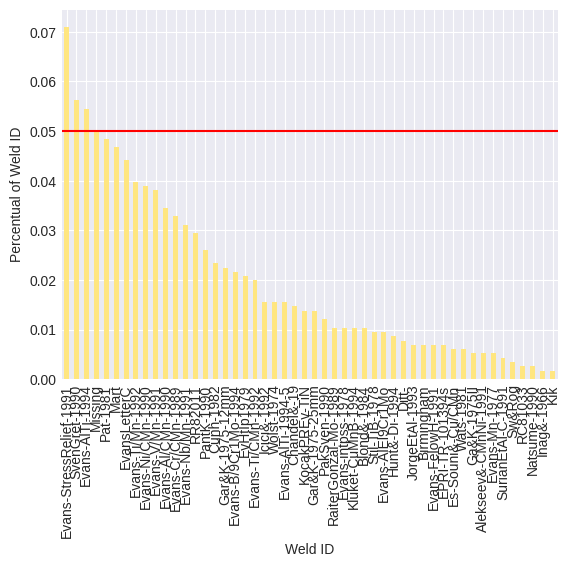

In [143]:
verify_pct_of_categories(X_train,['Weld ID'])


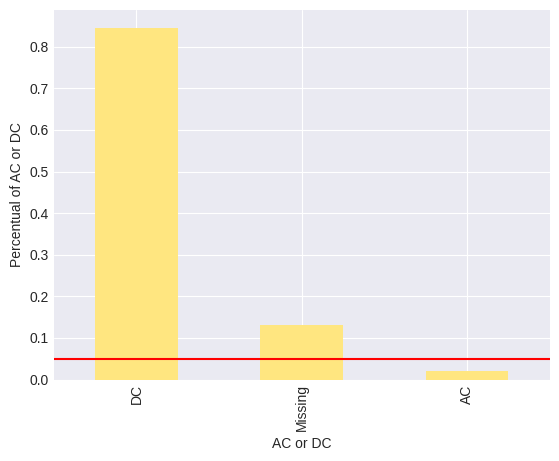

In [144]:
verify_pct_of_categories(X_train,['AC or DC'])


## Categorical Encoding


Having added the "Missing" category to the dataset, performing categorical imputation, we are now going to use DecisionTreeEncoder to try to capture a monotonic relationship between the categories and the target.

In [145]:
# Not working
""" import pandas as pd
from feature_engine.encoding import DecisionTreeEncoder

X_train_non_null = X_train[y_train["Yield strength / MPa"].notnull()]
y_train_non_null = y_train[y_train["Yield strength / MPa"].notnull()]["Yield strength / MPa"]

woe_encoder = DecisionTreeEncoder(cv=2)

woe_encoder.fit(X_train_non_null, y_train_non_null)

X_train_encoded = woe_encoder.transform(X_train)
X_valid_encoded = woe_encoder.transform(X_valid)
X_test_encoded = woe_encoder.transform(X_test)"""

' import pandas as pd\nfrom feature_engine.encoding import DecisionTreeEncoder\n\nX_train_non_null = X_train[y_train["Yield strength / MPa"].notnull()]\ny_train_non_null = y_train[y_train["Yield strength / MPa"].notnull()]["Yield strength / MPa"]\n\nwoe_encoder = DecisionTreeEncoder(cv=2)\n\nwoe_encoder.fit(X_train_non_null, y_train_non_null)\n\nX_train_encoded = woe_encoder.transform(X_train)\nX_valid_encoded = woe_encoder.transform(X_valid)\nX_test_encoded = woe_encoder.transform(X_test)'

In [147]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import umap

def one_hot_encode_and_reduce_multiple(X_train, X_val, X_test, n_components=2, random_state=42):


    categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

    # Inicializar o OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Ajustar o encoder nos dados de treino e transformar
    encoded_train = encoder.fit_transform(X_train[categorical_columns])
    encoded_val = encoder.transform(X_val[categorical_columns])
    encoded_test = encoder.transform(X_test[categorical_columns])

    # Nomear as colunas do one-hot encoding
    encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

    # Aplicar UMAP apenas nas colunas geradas pelo one-hot encoding
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)

    # Ajustar nos dados de treino e transformar também validação e teste
    reduced_train = reducer.fit_transform(encoded_train_df)
    reduced_val = reducer.transform(encoded_val_df)
    reduced_test = reducer.transform(encoded_test_df)

    # Retornar DataFrames com a dimensionalidade reduzida
    reduced_train_df = pd.DataFrame(reduced_train, columns=[f'UMAP_{i+1}' for i in range(n_components)])
    reduced_val_df = pd.DataFrame(reduced_val, columns=[f'UMAP_{i+1}' for i in range(n_components)])
    reduced_test_df = pd.DataFrame(reduced_test, columns=[f'UMAP_{i+1}' for i in range(n_components)])

    # Combinar as colunas numéricas originais com os resultados do UMAP
    X_train_numeric = X_train.drop(columns=categorical_columns).reset_index(drop=True)
    X_val_numeric = X_val.drop(columns=categorical_columns).reset_index(drop=True)
    X_test_numeric = X_test.drop(columns=categorical_columns).reset_index(drop=True)

    final_train = pd.concat([X_train_numeric, reduced_train_df], axis=1)
    final_val = pd.concat([X_val_numeric, reduced_val_df], axis=1)
    final_test = pd.concat([X_test_numeric, reduced_test_df], axis=1)

    return final_train, final_val, final_test


In [148]:
X_train, X_valid, X_test = one_hot_encode_and_reduce_multiple(X_train, X_valid, X_test, n_components=5)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Dealing with NaN

We will use the reference paper in the dataset to extract some tips to deal with the missing values

![imgs/deal_with_nan1.png](attachment:image.png)

So, phosphorus and sulphur, we will imput with the mean, or other more advanced techniques
Other elements, such as Mn, Ni, it would be zero.
We now need to find what to do with the others based on these elementes

![imgs/aa.png](attachment:image.png)

We need also take into account if the missing values are MAR, MCAR or MNAR, and for each type we need to use a different startegy

Other thing we are gonna look is if the fact of the data is missing is a valuable information

First of all, let's create the functions to do some data inputation

In [149]:
columns_to_drop = ["Hardness / kgmm-2",
        "50 % FATT",
        "Primary ferrite in microstructure / %",
        "Ferrite with second phase / %",
        "Acicular ferrite / %",
        "Martensite / %",
        "Ferrite with carbide aggreagate / %",]

X_train.drop(columns=columns_to_drop, inplace=True)
X_valid.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)

In [150]:
numeric_features=get_numerical_variables(X_train).tolist()

In [151]:
def create_missing_value_column(df, columns, name='tem_nan'):
    df[name] = df[columns].isna().any(axis=1).astype(int)
    return df


group_1 = ["Carbon concentration / (weight%)",
        "Silicon concentration / (weight%)",
        "Manganese concentration / (weight%)",
        "Sulphur concentration / (weight%)",
        "Phosphorus concentration / (weight%)",]

group_2 = ["Nickel concentration / (weight%)",
        "Chromium concentration / (weight%)",
        "Molybdenum concentration / (weight%)",
        "Vanadium concentration / (weight%)",
        "Copper concentration / (weight%)",
        ]

group_3 = ["Cobalt concentration / (weight%)",
        "Tungsten concentration / (weight%)",]

group_4 = ["Oxygen concentration / parts per million by weight",
        "Titanium concentration / parts per million by weight",
        "Nitrogen concentration / parts per million by weight",
        "Aluminium concentration / parts per million by weight",
        "Boron concentration / parts per million by weight",
        "Niobium concentration / parts per million by weight",
        ]

group_5 = ["Tin concentration / parts per million by weight",
           "Arsenic concentration / parts per million by weight",
        "Antimony concentration / parts per million by weight",]


X_train = create_missing_value_column(X_train, group_1, "group_1")
X_valid = create_missing_value_column(X_valid, group_1, "group_1")
X_test = create_missing_value_column(X_test, group_1, "group_1")

X_train = create_missing_value_column(X_train, group_2, "group_2")
X_valid = create_missing_value_column(X_valid, group_2, "group_2")
X_test = create_missing_value_column(X_test, group_2, "group_2")

X_train = create_missing_value_column(X_train, group_3, "group_3")
X_valid = create_missing_value_column(X_valid, group_3, "group_3")
X_test = create_missing_value_column(X_test, group_3, "group_3")

X_train = create_missing_value_column(X_train, group_4, "group_4")
X_valid = create_missing_value_column(X_valid, group_4, "group_4")
X_test = create_missing_value_column(X_test, group_4, "group_4")

X_train = create_missing_value_column(X_train, group_5, "group_5")
X_valid = create_missing_value_column(X_valid, group_5, "group_5")
X_test = create_missing_value_column(X_test, group_5, "group_5")

In [153]:
def mean_imputation(df, column, mean_value):
    """Impute missing values in a column using the provided mean."""
    df[column].fillna(mean_value, inplace=True)

def impute_with_zero(df, column):
    """Impute missing values with zero."""
    df[column].fillna(0, inplace=True)

In [154]:
X_CATEGORICAL_FEATURES = list(get_categorical_variables(X_train))
X_NUMERICAL_FEATURES = list(get_numerical_variables(X_train))

In [155]:
# Create missingness indicators in X_train
for column in X_NUMERICAL_FEATURES + X_CATEGORICAL_FEATURES:
  X_train[column + '_missing'] = X_train[column].isnull().astype(int)
  X_valid[column + '_missing'] = X_valid[column].isnull().astype(int)
  X_test[column + '_missing'] = X_test[column].isnull().astype(int)

# Analyze missingness for numerical features
mar_columns = []
mnar_columns = []

for column in X_NUMERICAL_FEATURES:

    if X_train[column].isnull().mean() == 0:
        continue  # No missing data in this column

    missing_indicator = column + '_missing'
    related = False
    for other_column in X_NUMERICAL_FEATURES:
        if other_column == column:
            continue

        # Only consider rows where both variables are not missing
        valid_rows = X_train[[missing_indicator, other_column]].dropna()
        if valid_rows.shape[0] < 2:
            continue

        # Calculate Pearson correlation and p-value
        corr_coeff, p_value = pearsonr(valid_rows[missing_indicator], valid_rows[other_column])

        # If p-value is less than 0.001, consider it MAR
        if p_value < 0.001:
            related = True
            break

    if related:
        mar_columns.append(column)
    else:
        mnar_columns.append(column)

print("Columns considered MAR:", mar_columns)
print("Columns considered MNAR:", mnar_columns)

Columns considered MAR: ['Sulphur concentration / (weight%)', 'Phosphorus concentration / (weight%)', 'Nickel concentration / (weight%)', 'Chromium concentration / (weight%)', 'Molybdenum concentration / (weight%)', 'Vanadium concentration / (weight%)', 'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)', 'Tungsten concentration / (weight%)', 'Oxygen concentration / parts per million by weight', 'Titanium concentration / parts per million by weight', 'Nitrogen concentration / parts per million by weight', 'Aluminium concentration / parts per million by weight', 'Boron concentration / parts per million by weight', 'Niobium concentration / parts per million by weight', 'Tin concentration / parts per million by weight', 'Arsenic concentration / parts per million by weight', 'Antimony concentration / parts per million by weight', 'Current / A', 'Voltage / V', 'Interpass temperature / °C', 'Post weld heat treatment temperature / °C', 'Post weld heat treatment time / hours

<ipython-input-155-1edfc699c9a3>:28: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

<ipython-input-155-1edfc699c9a3>:28: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

<ipython-input-155-1edfc699c9a3>:28: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

<ipython-input-155-1edfc699c9a3>:28: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

<ipython-input-155-1edfc699c9a3>:28: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

<ipython-input-155-1edfc699c9a3>:28: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

<ipython-input-155-1edfc699c9a3>:28: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

<ipython-input-155-1edfc699c9a3>:28: ConstantInputWarning:

An input 

In [156]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Imputation for Phosphorus (P) and Sulphur (S) using mean imputation
p_column = "Phosphorus concentration / (weight%)"
s_column = "Sulphur concentration / (weight%)"

p_mean_train = X_train[p_column].mean()
s_mean_train = X_train[s_column].mean()
p_mean_valid = X_train[p_column].mean()
s_mean_valid = X_train[s_column].mean()
p_mean_test = X_train[p_column].mean()
s_mean_test = X_train[s_column].mean()

mean_imputation(X_train, p_column, p_mean_train)
mean_imputation(X_valid, p_column, p_mean_valid)
mean_imputation(X_test, p_column, p_mean_test)

mean_imputation(X_train, s_column, s_mean_train)
mean_imputation(X_valid, s_column, s_mean_valid)
mean_imputation(X_test, s_column, s_mean_test)

# Imputation for Manganese (Mn) and Nickel (Ni) with zero
mn_column = "Manganese concentration / (weight%)"
ni_column = "Nickel concentration / (weight%)"

impute_with_zero(X_train, mn_column)
impute_with_zero(X_valid, mn_column)
impute_with_zero(X_test, mn_column)

impute_with_zero(X_train, ni_column)
impute_with_zero(X_valid, ni_column)
impute_with_zero(X_test, ni_column)

# Imputation for MAR columns using IterativeImputer (EM approximation for MLE)
imputed_columns = [p_column, s_column, mn_column, ni_column]
mar_columns_to_impute = [col for col in mar_columns if col not in imputed_columns]

# Use IterativeImputer (EM) to impute MAR columns, fitting only on training data
imputer = IterativeImputer(max_iter=10, random_state=0)

# Fit on X_train only
imputer.fit(X_train[mar_columns_to_impute])

# Transform each set individually to avoid data leakage
X_train[mar_columns_to_impute] = imputer.transform(X_train[mar_columns_to_impute])
X_valid[mar_columns_to_impute] = imputer.transform(X_valid[mar_columns_to_impute])
X_test[mar_columns_to_impute] = imputer.transform(X_test[mar_columns_to_impute])

# Imputation for MNAR columns using KNN imputation
numerical_mnar_columns = [col for col in mnar_columns if col in X_NUMERICAL_FEATURES]

if numerical_mnar_columns:
    # Use KNN imputation
    imputer = KNNImputer(n_neighbors=5)
    # Fit on X_train
    imputer.fit(X_train[X_NUMERICAL_FEATURES])
    # Impute X_train, X_valid, X_test
    X_train[X_NUMERICAL_FEATURES] = imputer.transform(X_train[X_NUMERICAL_FEATURES])
    X_valid[X_NUMERICAL_FEATURES] = imputer.transform(X_valid[X_NUMERICAL_FEATURES])
    X_test[X_NUMERICAL_FEATURES] = imputer.transform(X_test[X_NUMERICAL_FEATURES])

<ipython-input-153-61d72f5e058c>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-153-61d72f5e058c>:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or d

In [165]:
if (X_train.isnull().sum().sum(), X_test.isnull().sum().sum(), X_valid.isnull().sum().sum()) == (0, 0, 0):
  print("All missing values were imputed!")

All missing values were imputed!


MCAR -> mean, constant
MAR ->
MNAR ->

Our ideal strategy:

the last columns we will delete

the first columns we will check if we are gonna replace with zero, mean, or KNN.

we will create a column related to the missing values of some groups of columns

Do one hot encoding in the categorical features, and after that PCA on everything related to the categorical features


## Transformation of Variables

Let's try to make the variables more symmetrically distributed (which helps in training the models). Let's check some transformations:

In [ ]:
def view_tranformations(X_train,columns_names,transformation_name='YeoJohnson'):

  df_before = pd.DataFrame({'Skew':[X_train[feature].skew() for feature in columns_names],
                              'Feature':[feature for feature in columns_names]})

  if transformation_name in ['log','Log','LOG','ln','logaritmo natural']:
    tf = vt.LogTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                             'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Log-Transformation'
  elif transformation_name in ['boxcox','Boxcox','box cox','box-cox','Box-cox','Box cox']:
    tf = vt.BoxCoxTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Boxcox-Transformation'
  elif transformation_name in ['YeoJohnson','Yeo Johnson','Yeo-Johnson','yeojohnson','yeo johnson','yeo-johnson']:
    tf = vt.YeoJohnsonTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after YeoJohnson-Transformation'
  elif transformation_name in ['Reciprocal','Inverse','reciprocal','inverse','inverso','reciproco']:
    tf = vt.ReciprocalTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Reciprocal-Transformation'
  else:
    raise Exception('\nColoque uma das transformações válidas:\nLog\nBox-Cox\nYeo-Johnson\nReciprocal')


  f, ax = plt.subplots(figsize=(6, 6))
  sns.set_color_codes("muted")
  sns.set_style('darkgrid')
  sns.barplot(x="Skew", y="Feature", data=df_before,
              label="Before", alpha=0.5)

  sns.set_color_codes("muted")
  sns.barplot(x="Skew", y="Feature", data=df_after,
              label="After",alpha=1)

  ax.legend(ncol=2, loc="best", frameon=True)
  ax.set(ylabel="",
        xlabel=label)
  sns.despine(left=True, bottom=True)
  plt.grid()
  plt.show()

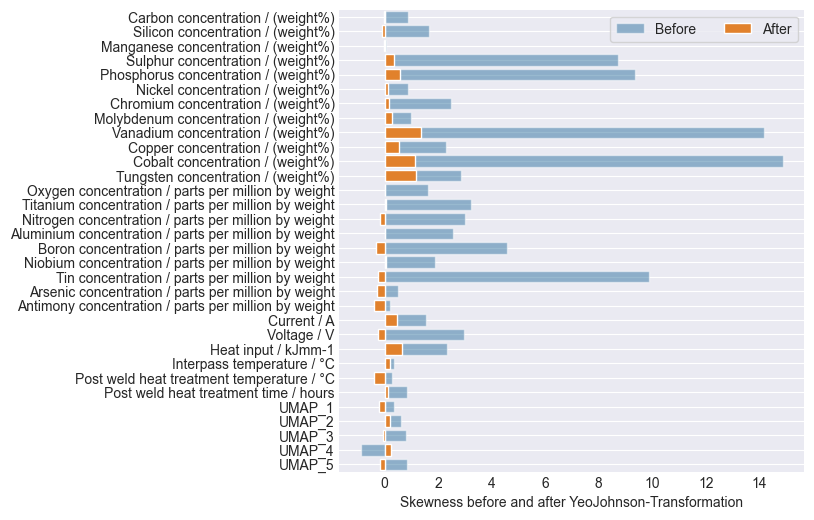

In [ ]:
view_tranformations(X_train_knn, numeric_features)

In [ ]:
yeojohnson_transform=vt.YeoJohnsonTransformer(variables=numeric_features)

yeojohnson_transform.fit(X_train)

X_train=yeojohnson_transform.transform(X_train)
X_valid=yeojohnson_transform.transform(X_valid)
X_test=yeojohnson_transform.transform(X_test)

ValueError: Some of the variables in the dataset contain NaN. Check and remove those before using this transformer.

In [ ]:
def diagnostic_plots(df,variable,lib):
  if lib=='plotly' or lib=='Plotly':
    fig=make_subplots(rows=1, cols=3,subplot_titles=('Histograma','Gráfico QQ','Box-Plot'))
    #Vamos plotar o Histograma
    fig_hist=ff.create_distplot([df[variable].values], [variable])
    fig.add_trace(go.Histogram(fig_hist['data'][0],
                              marker_color='#FFCC00',
                              ), row=1, col=1)

    fig.add_trace(go.Scatter(fig_hist['data'][1],
                         line=dict(color='#FF851B')
                        ), row=1, col=1)
    #Vamos plotar o gráfico QQ
    qq = stats.probplot(df[variable], dist='norm', sparams=(1))
    x = np.array([qq[0][0][0], qq[0][0][-1]])
    qq_df=pd.DataFrame({'x':np.array(qq[0][0].tolist()),
                    'y':np.array(qq[0][1].tolist()),
                    'index':df.index.tolist()},index=None)
    fig_qq=go.Scatter(x=qq_df['x'],
                            y=qq_df['y'],
                            mode='markers',
                            name=variable,
                            text=qq_df['index'],
                            marker_color='rgba(31, 150, 139, 0.9)')

    fig_qq.update(mode='markers', marker_line_width=0.15, marker_size=5)
    fig.append_trace(fig_qq, row=1, col=2)
    fig.append_trace(go.Scatter(x=x,
                                y=qq[1][1] + qq[1][0]*x,
                                mode='lines',
                                name='Normal',
                                marker_color='rgba(255, 90, 0, 0.9)'), row=1, col=2)
    fig.layout.update(title='Resumo da Variável '+ variable)
    #Vamos o gráfico Box-Plot
    fig_box=go.Box(y=df[variable],
                  boxpoints='all',
                  jitter=0.4, # add some jitter for a better separation between points
                  boxmean='sd',
                  text=df.index.tolist(),
                  name='Box-Plot',
                  marker_color='#FFCC00',
                  line_color='#FF851B')
    fig.append_trace(fig_box, row=1, col=3)
    fig.show()

  elif lib=='matplotlib' or lib=='pyplot':
    #function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x=variable, kde=True,color='#E0B100',stat="density")
    plt.title('Histogram')

    # Q-Q plot
    ax=plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    ax.get_lines()[0].set_markersize(7.0)
    ax.get_lines()[0].set_markerfacecolor('#44B1A5')
    ax.get_lines()[0].set_color('#44B1A5')

    ax.get_lines()[1].set_markerfacecolor('#FF7627')
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=variable, data=df,color='#FFCC00',linewidth=2.5)
    sns.swarmplot(y=variable, data=df.iloc[0:300], color="#FFE680")
    plt.title('Boxplot')

    plt.suptitle('Distribuição de '+ variable, fontsize=16)
    plt.show()

  else:
    print('Escolha como library (argumento lib) ou "matplotlib" ou "plotly"!')


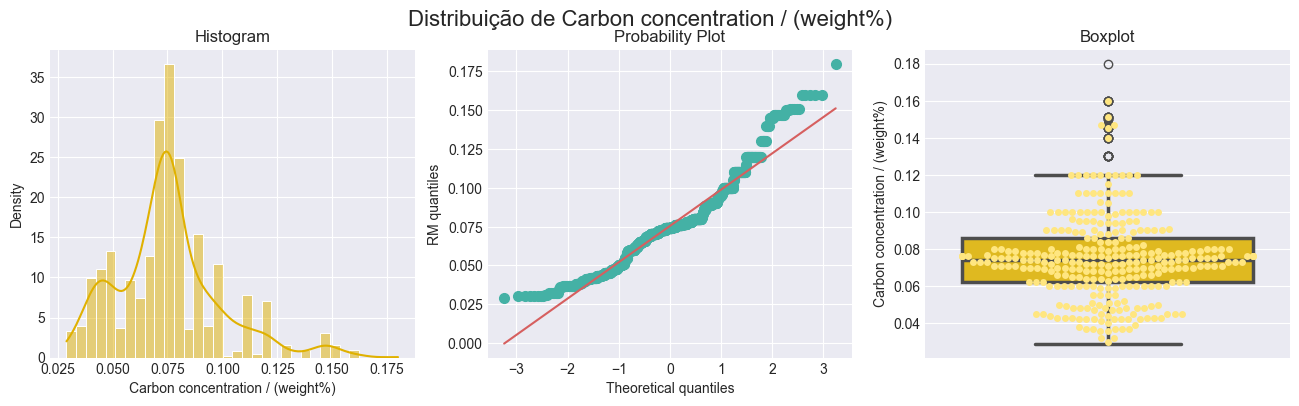

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



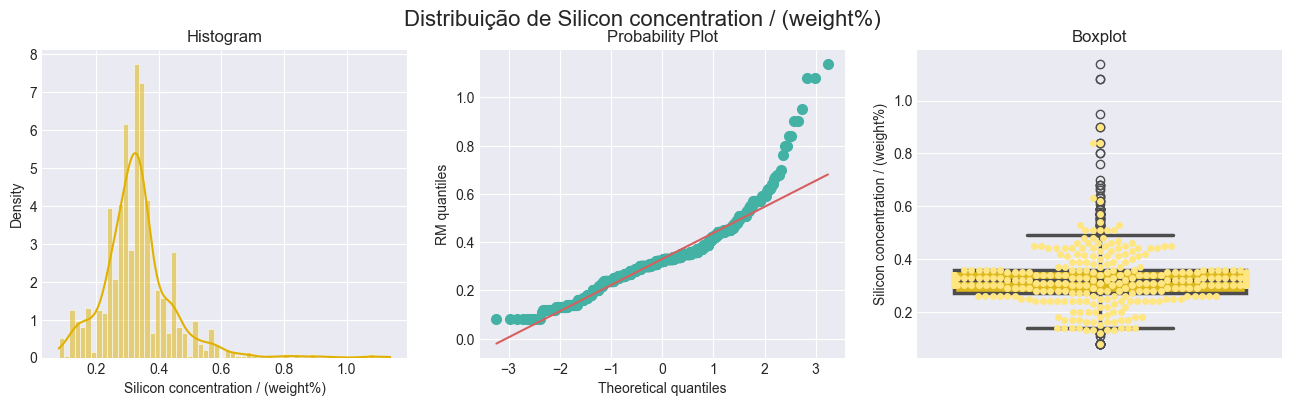

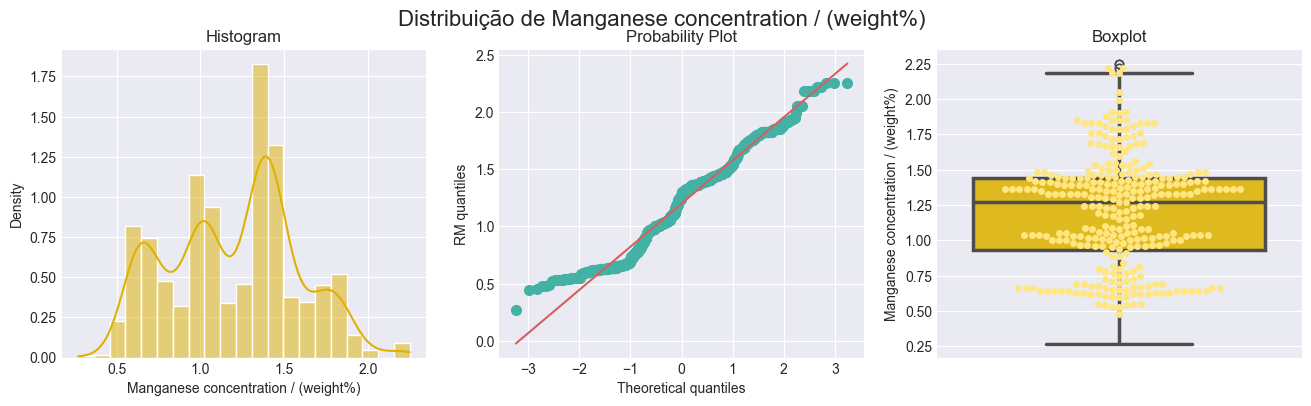

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

38.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

41.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



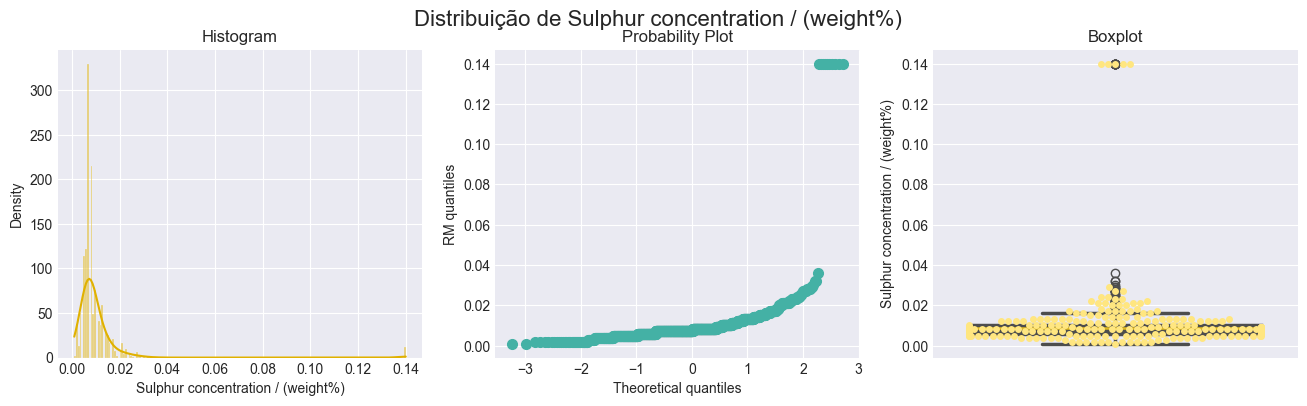

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

50.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

53.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



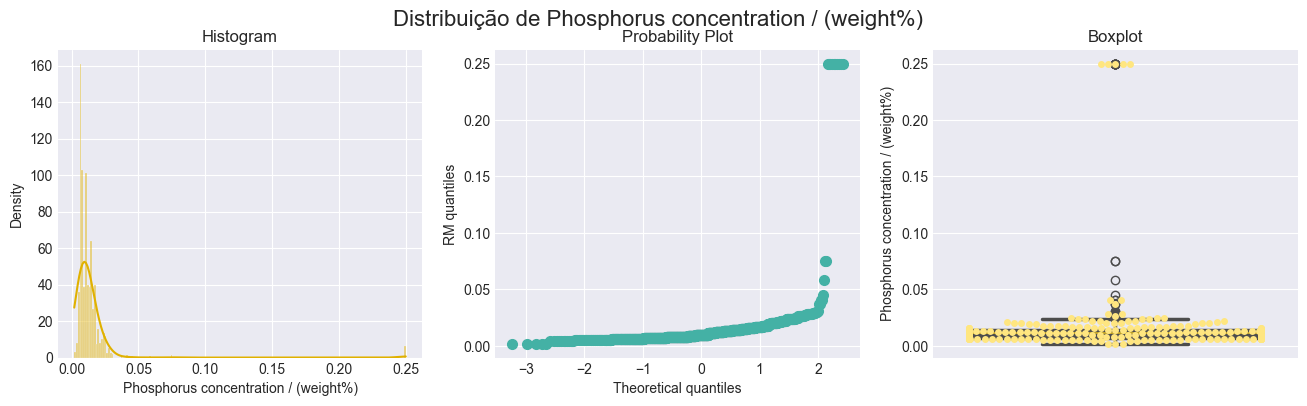

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



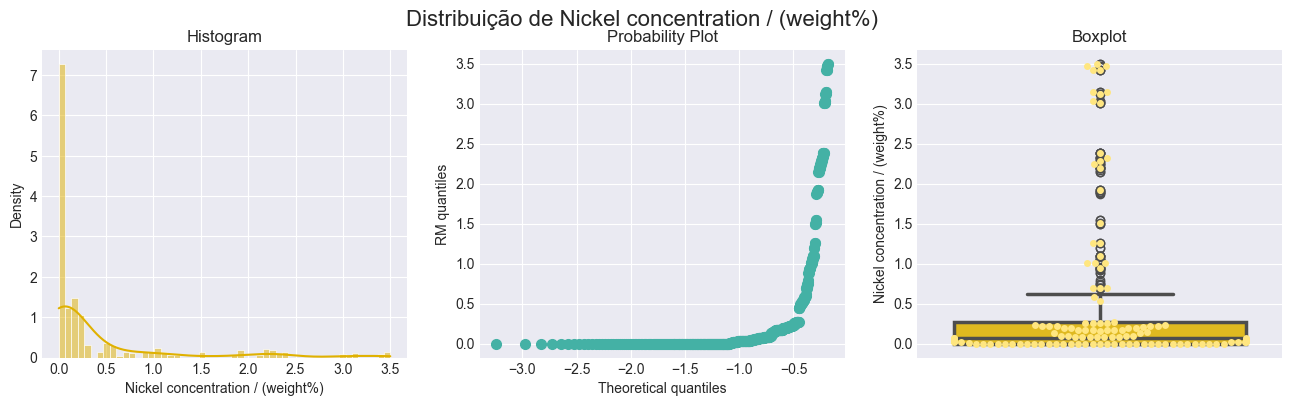

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

14.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

17.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



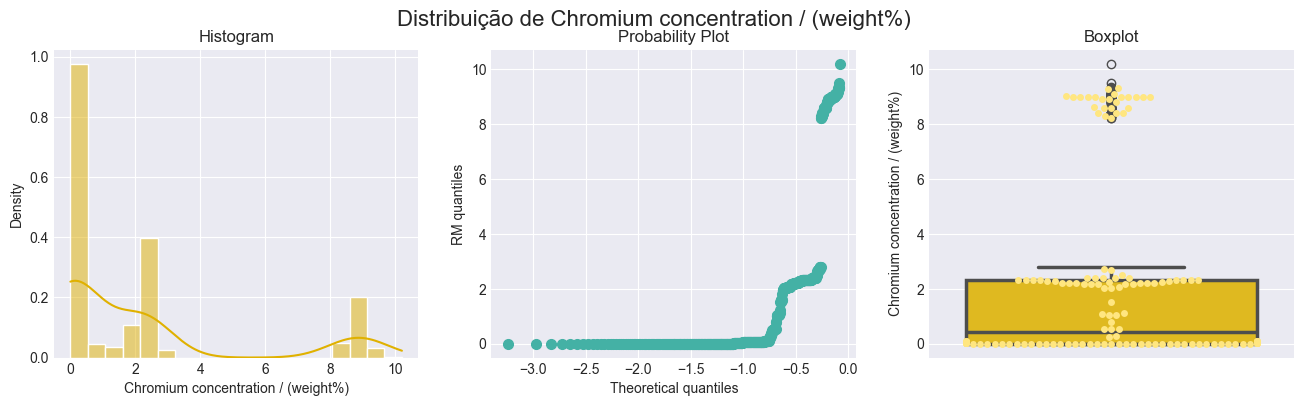

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



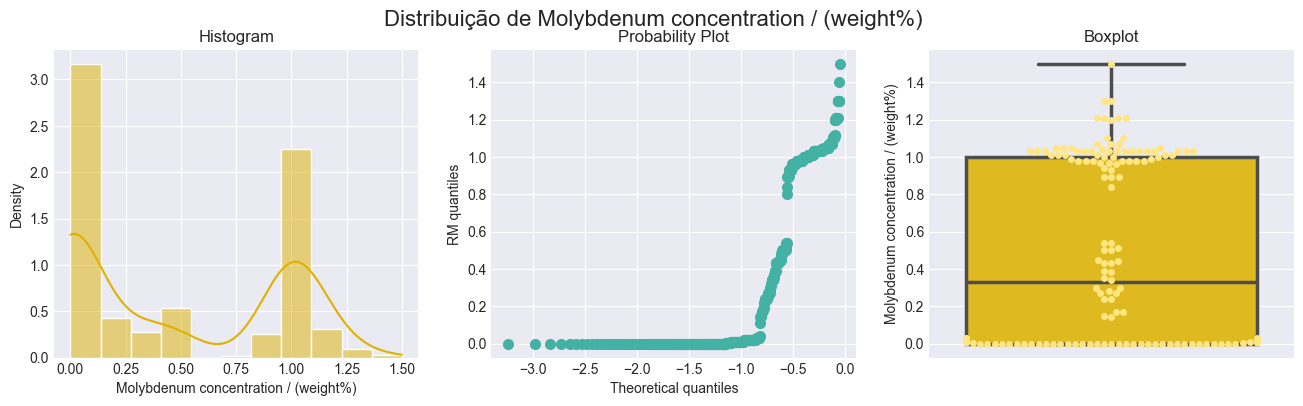

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

51.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

53.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



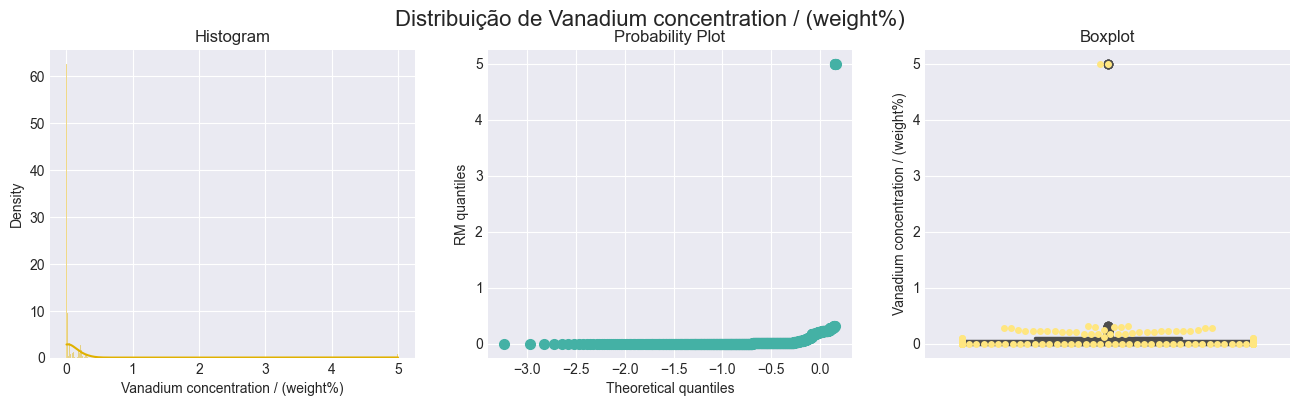

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



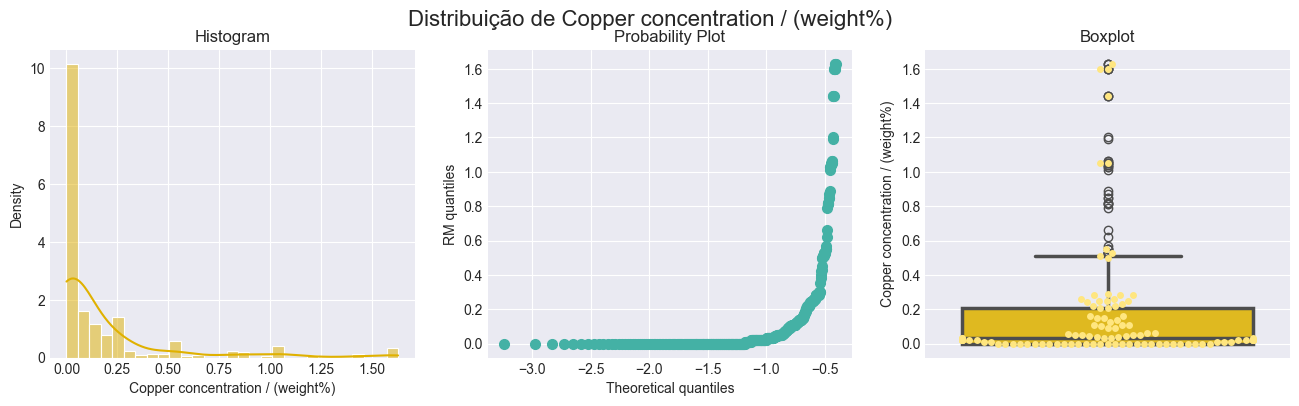

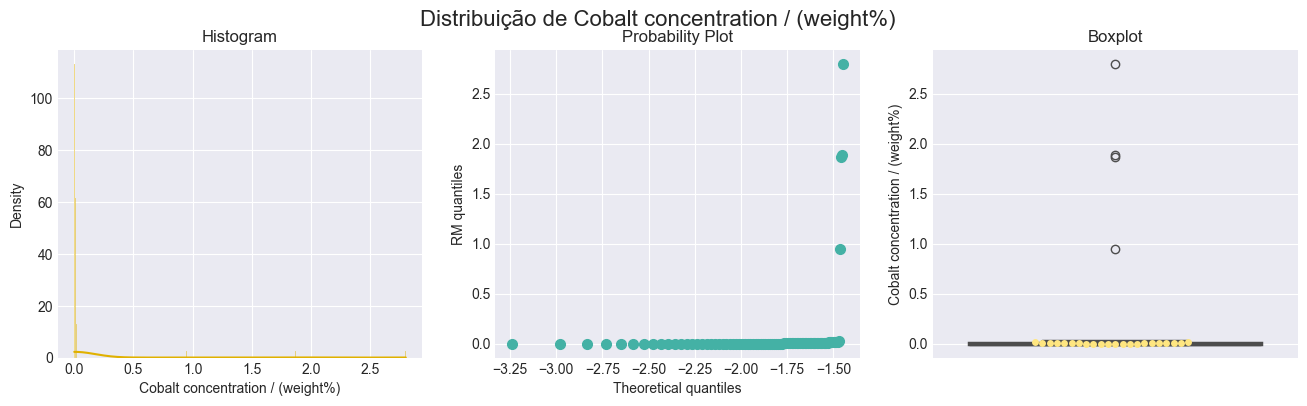

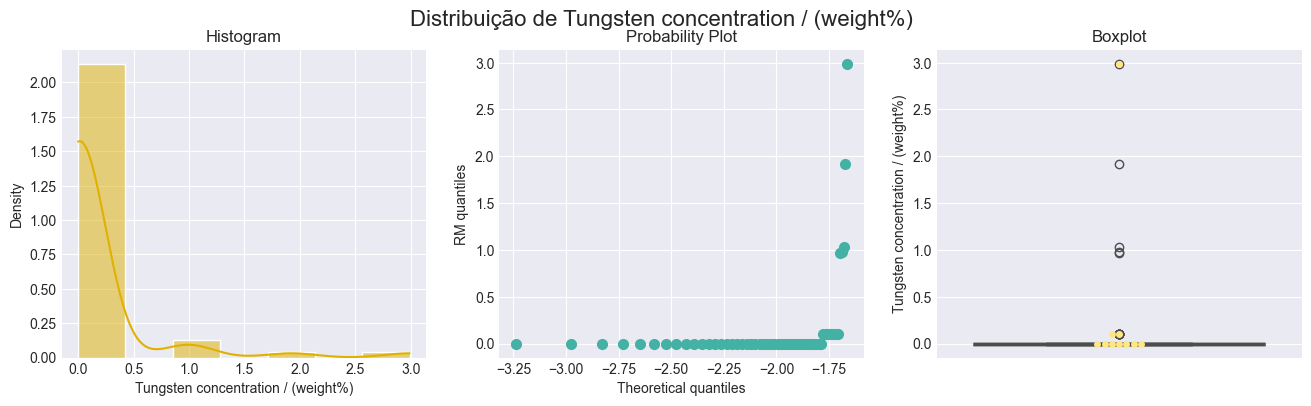

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



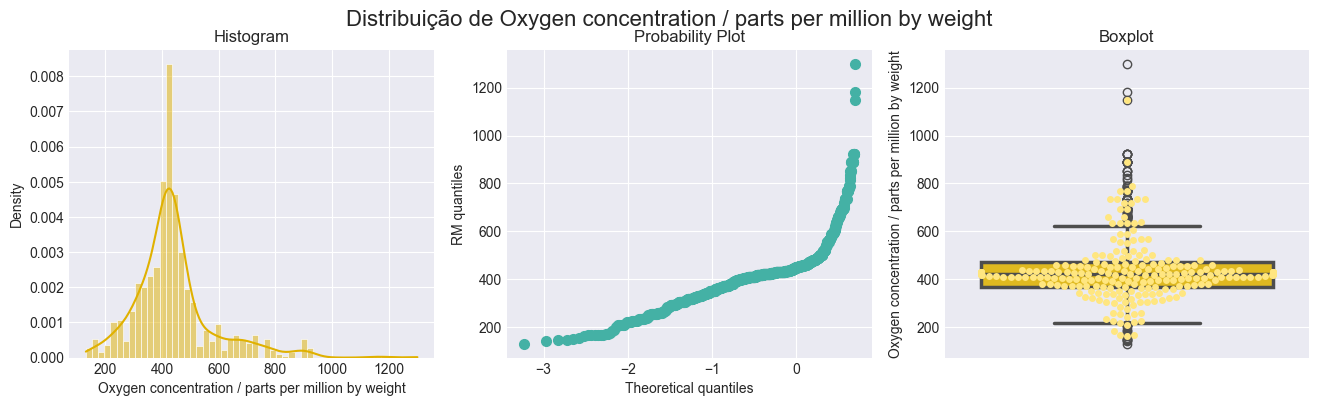

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



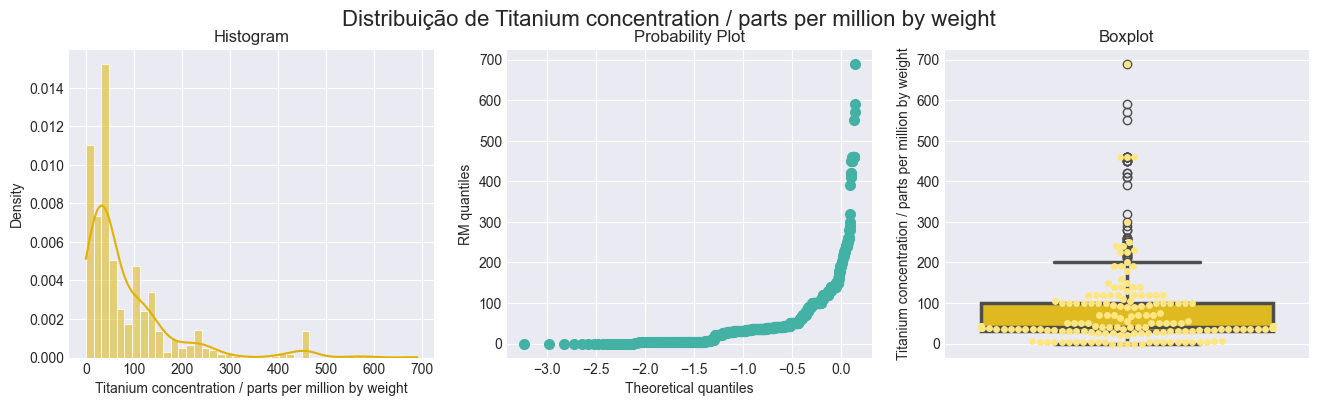

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



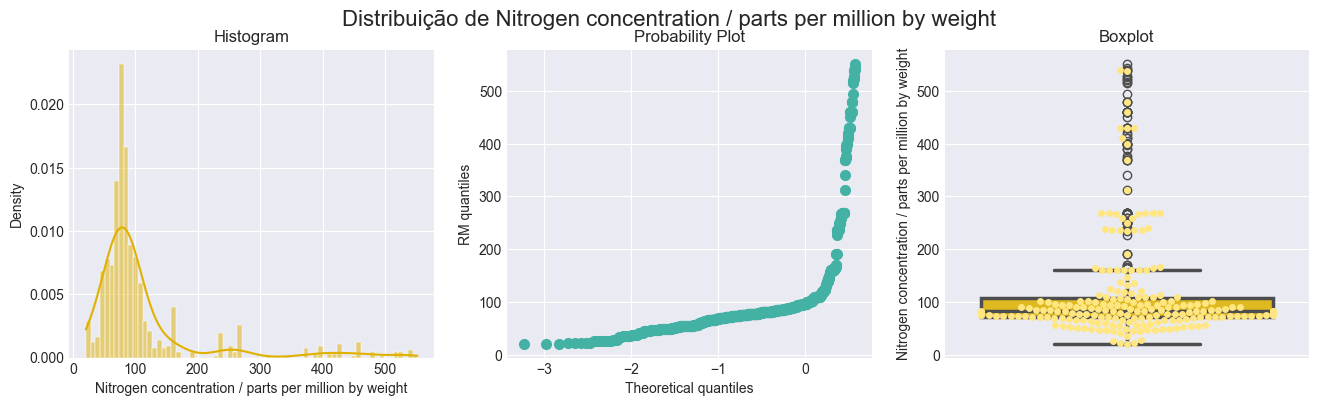

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



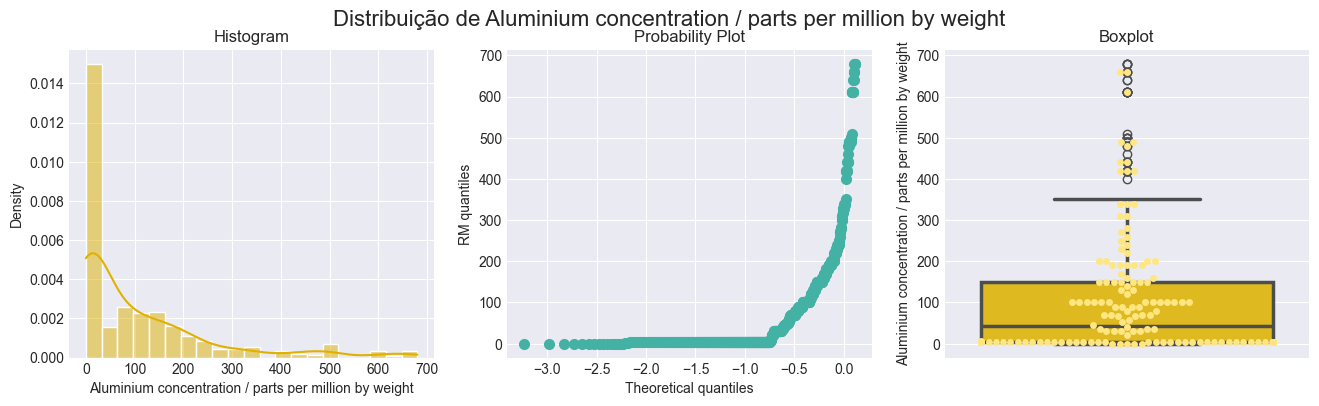

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

32.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

37.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



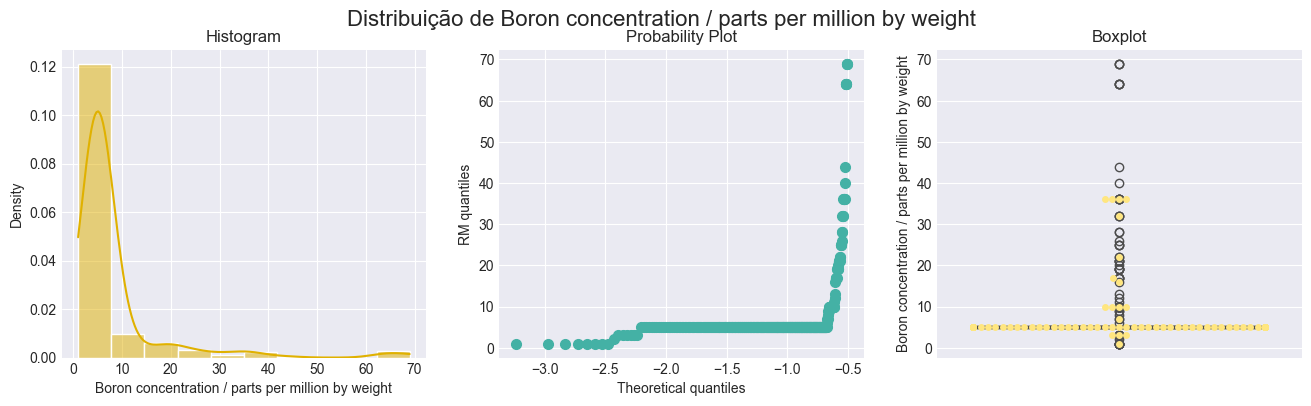

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

25.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

28.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



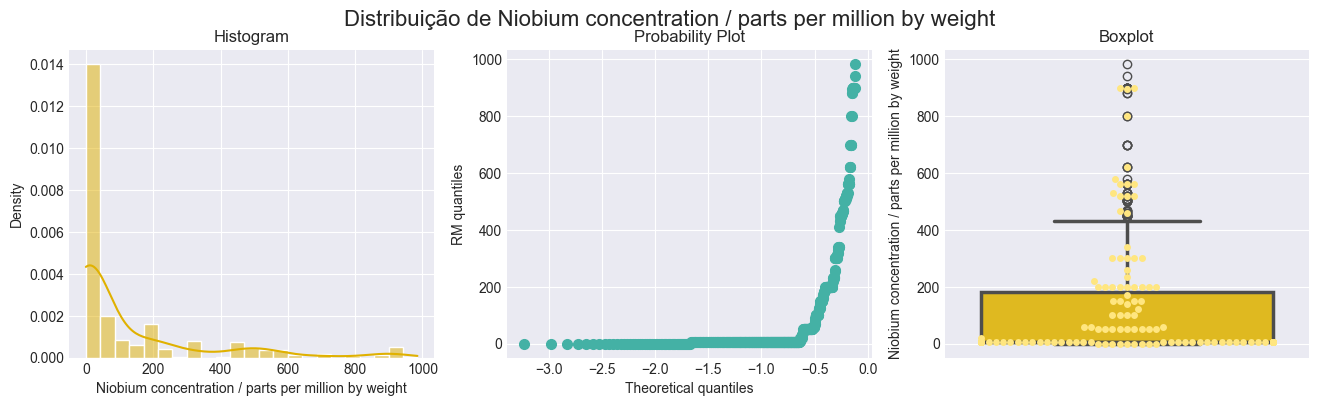

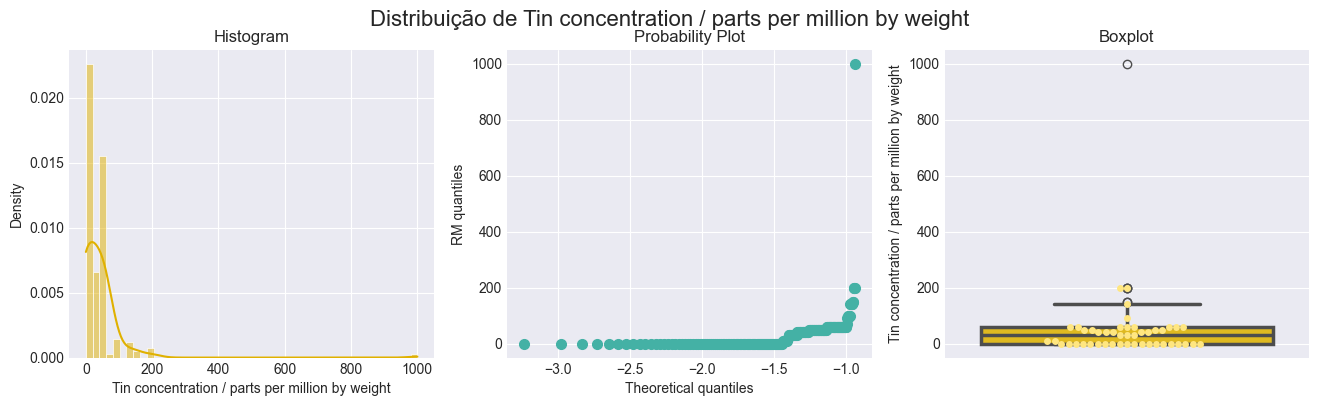

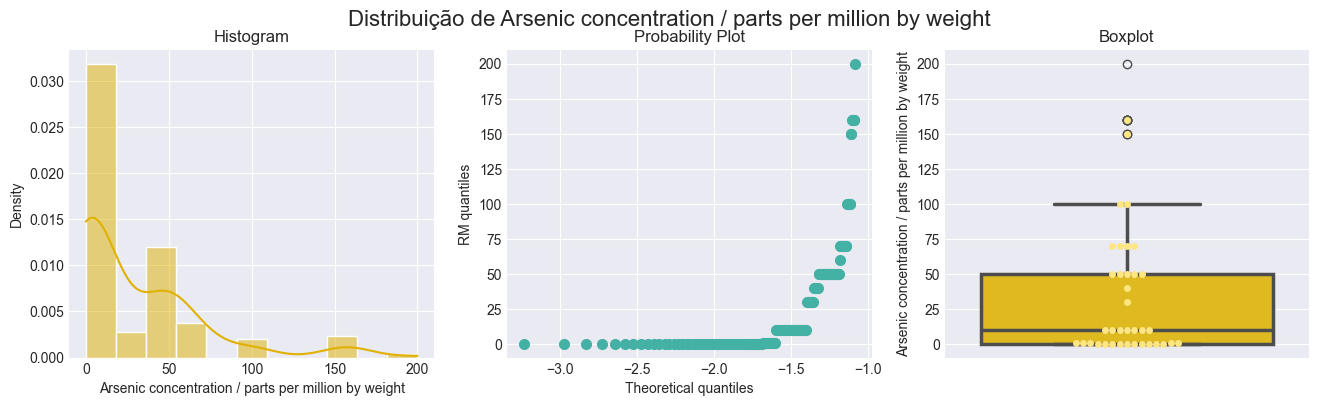

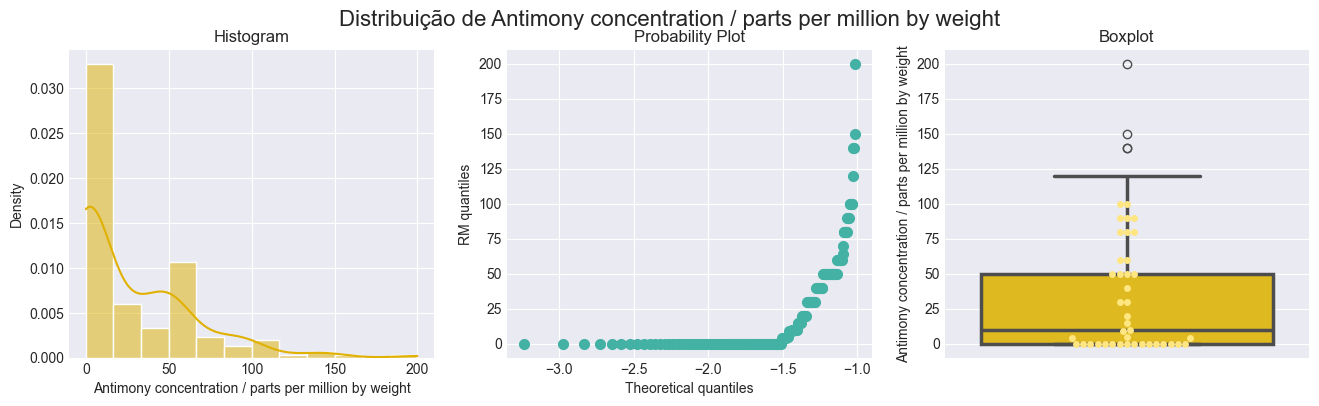

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

46.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

49.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



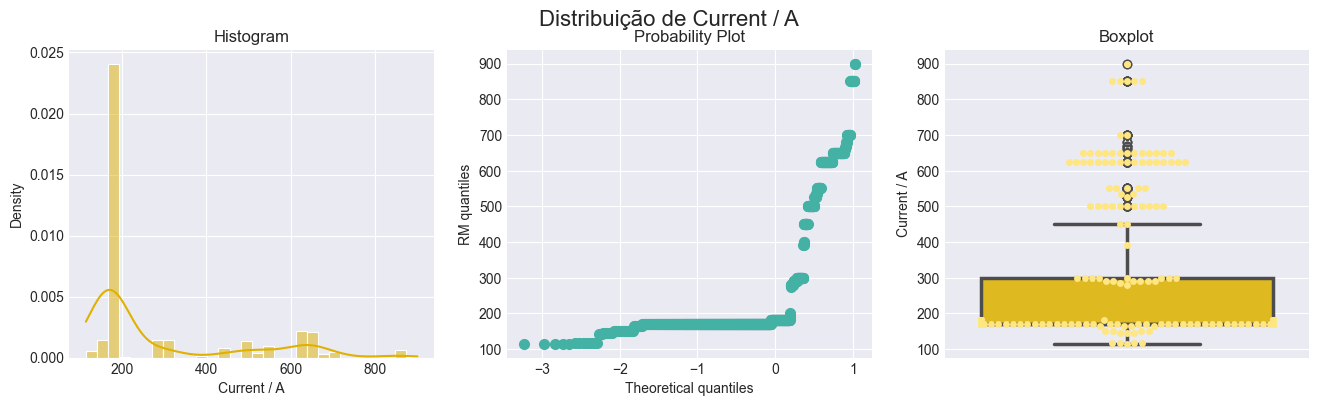

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

35.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

37.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



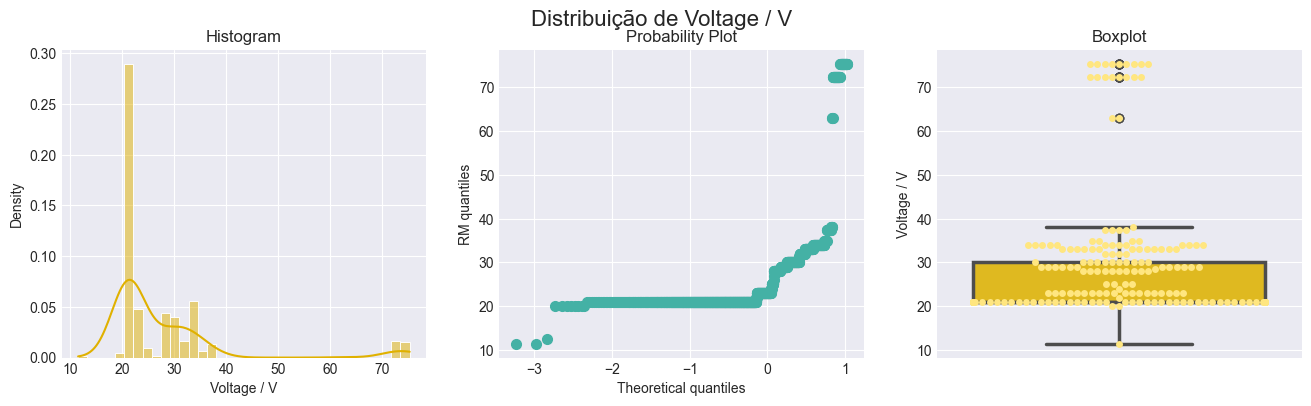

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

51.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



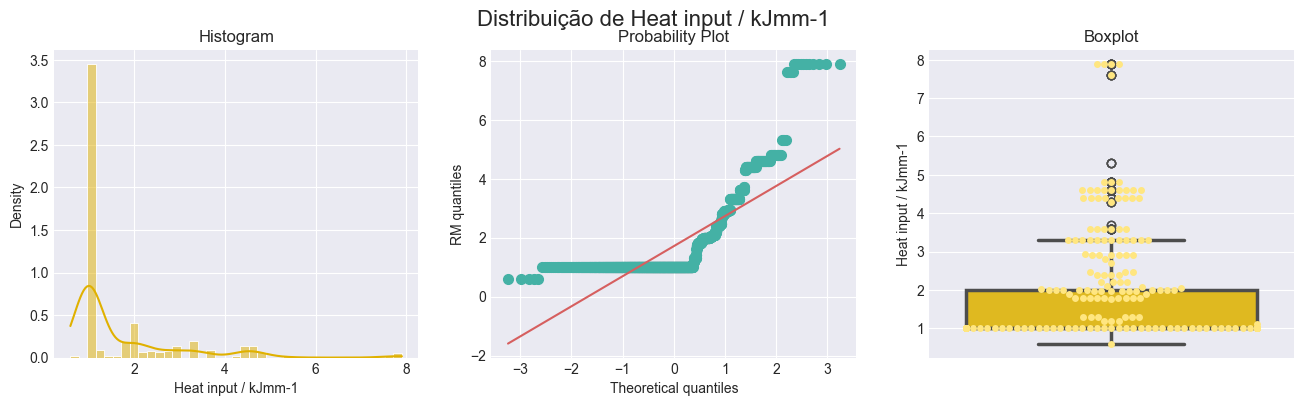

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

51.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

53.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



KeyboardInterrupt: 

In [ ]:
for feature in numeric_features:
  diagnostic_plots(X_train,feature,'matplotlib')